In [22]:
import cv2
import os
import numpy as np


In [23]:
def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image


In [25]:
def flip_image(image, flipCode):
    return cv2.flip(image, flipCode)


In [26]:
def flip_annotations_horizontally(annotations, image_width, flipCode):
    new_annotations = []
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())

        if flipCode == 1:  # Flip horizontal
            x_center = 1 - x_center
        elif flipCode == 0:  # Flip vertical
            y_center = 1 - y_center
        # Notez que flipCode == -1 nécessiterait un traitement supplémentaire si vous voulez le gérer

        new_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}\n")
    return new_annotations


In [27]:
def adjust_brightness(image, value):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)


In [28]:
# Fonction pour lire les annotations
def read_annotation(file_path):
    with open(file_path, 'r') as file:
        annotations = file.readlines()
    return annotations


In [29]:
# Fonction pour écrire les nouvelles annotations
def write_annotation(new_file_path, annotations):
    with open(new_file_path, 'w') as file:
        for annotation in annotations:
            file.write(annotation)


In [30]:
def apply_random_transformation(image, annotations, transformation_type):
    if transformation_type == 'flip':
        flipCode = random.choice([-1, 0, 1])  # -1, 0, 1 pour différents types de flip
        transformed_image = flip_image(image, flipCode)
        transformed_annotations = flip_annotations_horizontally(annotations, image.shape[1], flipCode)

    elif transformation_type == 'brightness':
        brightness_value = random.randint(-50, 50)
        transformed_image = adjust_brightness(image, brightness_value)
        transformed_annotations = annotations  # Aucun changement pour les annotations

    return transformed_image, transformed_annotations


In [31]:
def process_images_annotations(images_directory, annotations_directory, new_images_directory, new_annotations_directory, num_times_per_transformation):
    new_images_count = 0
    for filename in os.listdir(images_directory):
        if filename.endswith(".jpg"):
            file_path = os.path.join(images_directory, filename)
            annotation_path = os.path.join(annotations_directory, filename.replace('.jpg', '.txt'))

            for transformation_type in ['flip', 'brightness']:
                for _ in range(num_times_per_transformation):
                    image = cv2.imread(file_path)
                    annotations = read_annotation(annotation_path)

                    transformed_image, transformed_annotations = apply_random_transformation(image, annotations, transformation_type)
                    new_image_file = os.path.join(new_images_directory, f"{transformation_type}_image_{new_images_count}.jpg")
                    new_annotation_file = os.path.join(new_annotations_directory, f"{transformation_type}_annotation_{new_images_count}.txt")

                    cv2.imwrite(new_image_file, transformed_image)
                    write_annotation(new_annotation_file, transformed_annotations)

                    new_images_count += 1


In [32]:
# Les chemins des dossiers
base_directory = "raw_data/EpicureAi.v4i.yolov8/"
train_images_directory = os.path.join(base_directory, "train/images")
train_annotations_directory = os.path.join(base_directory, "train/labels")
validation_images_directory = os.path.join(base_directory, "valid/images")
validation_annotations_directory = os.path.join(base_directory, "valid/labels")
new_dataset_directory = "raw_data/new_dataset"
new_images_directory = os.path.join(new_dataset_directory, "images")
new_annotations_directory = os.path.join(new_dataset_directory, "labels")

os.makedirs(new_images_directory, exist_ok=True)
os.makedirs(new_annotations_directory, exist_ok=True)


In [33]:
# Appliquer les transformations sur le dataset d'entraînement
process_images_annotations(train_images_directory, train_annotations_directory, new_images_directory, new_annotations_directory, 5)

# Appliquer les transformations sur le dataset de validation
process_images_annotations(validation_images_directory, validation_annotations_directory, new_images_directory, new_annotations_directory, 5)


In [14]:
'''# Créer les nouveaux dossiers s'ils n'existent pas
os.makedirs(new_images_directory, exist_ok=True)
os.makedirs(new_annotations_directory, exist_ok=True)

# Process train directory
process_images_annotations(train_images_directory, train_annotations_directory,
                           new_images_directory, new_annotations_directory,
                           [rotate_image, flip_image, adjust_brightness], target_images_count=3000)

# Process validation directory
process_images_annotations(validation_images_directory, validation_annotations_directory,
                           new_images_directory, new_annotations_directory,
                           [rotate_image, flip_image, adjust_brightness], target_images_count=3000)'''


"# Créer les nouveaux dossiers s'ils n'existent pas\nos.makedirs(new_images_directory, exist_ok=True)\nos.makedirs(new_annotations_directory, exist_ok=True)\n\n# Process train directory\nprocess_images_annotations(train_images_directory, train_annotations_directory,\n                           new_images_directory, new_annotations_directory,\n                           [rotate_image, flip_image, adjust_brightness], target_images_count=3000)\n\n# Process validation directory\nprocess_images_annotations(validation_images_directory, validation_annotations_directory,\n                           new_images_directory, new_annotations_directory,\n                           [rotate_image, flip_image, adjust_brightness], target_images_count=3000)"

In [34]:
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Compter les fichiers dans les dossiers
num_images = count_files(new_images_directory)
num_labels = count_files(new_annotations_directory)

print("Nombre d'images:", num_images)
print("Nombre de labels:", num_labels)


Nombre d'images: 30
Nombre de labels: 30


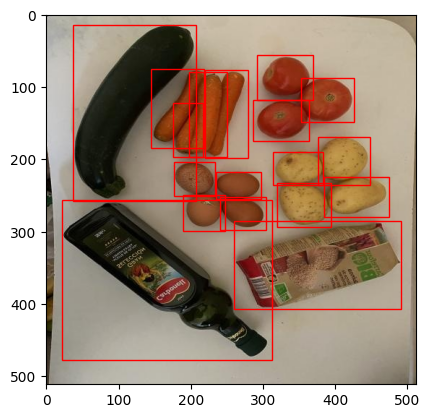

In [41]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image_with_annotations(image_file, annotation_file):
    # Lire l'image
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR en RGB

    # Lire les annotations
    with open(annotation_file, 'r') as file:
        annotations = file.readlines()

    # Afficher l'image
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Dessiner les boîtes englobantes
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        x_center, y_center, width, height = x_center * image.shape[1], y_center * image.shape[0], width * image.shape[1], height * image.shape[0]
        rect = patches.Rectangle((x_center - width / 2, y_center - height / 2), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Test avec une image et son label
sample_image_file = os.path.join(new_images_directory, "flip_image_24.jpg")
sample_annotation_file = os.path.join(new_annotations_directory, "flip_annotation_24.txt")

show_image_with_annotations(sample_image_file, sample_annotation_file)


In [62]:
import math

def adjust_annotations_for_rotation(annotations, image_width, image_height, angle):
    new_annotations = []
    # Convertir l'angle de degrés en radians pour la rotation
    angle_rad = math.radians(angle)

    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())

        # Convertir les coordonnées du centre en pixels
        x_center = x_center * image_width
        y_center = y_center * image_height
        bbox_width = width * image_width
        bbox_height = height * image_height

        # Calculer l'angle de rotation en fonction de l'angle donné
        if angle == 90:
            x_center_new = y_center / image_height
            y_center_new = 1 - (x_center / image_width)
        elif angle == 180:
            x_center_new = 1 - (x_center / image_width)
            y_center_new = 1 - (y_center / image_height)
        elif angle == 270:
            x_center_new = 1 - (y_center / image_height)
            y_center_new = x_center / image_width
        else:
            x_center_new = x_center / image_width
            y_center_new = y_center / image_height

        # Pour une rotation de 90 ou 270 degrés, échangez la largeur et la hauteur de la boîte englobante
        if angle in [90, 270]:
            width_new = bbox_height / image_width
            height_new = bbox_width / image_height
        else:
            width_new = bbox_width / image_width
            height_new = bbox_height / image_height

        # Ajouter la nouvelle annotation à la liste
        new_annotations.append(f"{class_id} {x_center_new} {y_center_new} {width_new} {height_new}\n")

    return new_annotations


In [63]:
import random
import os
import cv2

# ... [Les fonctions rotate_image, adjust_annotations_for_rotation, flip_image, flip_annotations_horizontally, adjust_brightness, read_annotation, write_annotation sont définies ici] ...

def apply_random_rotation(image, annotations):
    angle = random.choice([0, 90, 180, 270])  # Choix aléatoire d'angle
    transformed_image = rotate_image(image, angle)
    transformed_annotations = adjust_annotations_for_rotation(annotations, image.shape[1], image.shape[0], angle)
    return transformed_image, transformed_annotations

def process_images_annotations(images_directory, annotations_directory, new_images_directory, new_annotations_directory, num_rotations):
    new_images_count = 0
    for filename in os.listdir(images_directory):
        if filename.endswith(".jpg"):
            file_path = os.path.join(images_directory, filename)
            annotation_path = os.path.join(annotations_directory, filename.replace('.jpg', '.txt'))

            for _ in range(num_rotations):
                image = cv2.imread(file_path)
                annotations = read_annotation(annotation_path)

                transformed_image, transformed_annotations = apply_random_rotation(image, annotations)
                new_image_file = os.path.join(new_images_directory, f"rotated_image_{new_images_count}.jpg")
                new_annotation_file = os.path.join(new_annotations_directory, f"rotated_annotation_{new_images_count}.txt")

                cv2.imwrite(new_image_file, transformed_image)
                write_annotation(new_annotation_file, transformed_annotations)

                new_images_count += 1

# Chemins des dossiers
base_directory = "raw_data/EpicureAi.v4i.yolov8/"
train_images_directory = os.path.join(base_directory, "train/images")
train_annotations_directory = os.path.join(base_directory, "train/labels")
validation_images_directory = os.path.join(base_directory, "valid/images")
validation_annotations_directory = os.path.join(base_directory, "valid/labels")
new_dataset_directory = "raw_data/new_rotated_dataset"
new_images_directory = os.path.join(new_dataset_directory, "images")
new_annotations_directory = os.path.join(new_dataset_directory, "labels")

# Création des dossiers pour les nouvelles images et annotations si elles n'existent pas
os.makedirs(new_images_directory, exist_ok=True)
os.makedirs(new_annotations_directory, exist_ok=True)

# Appliquer 5 rotations aléatoires sur chaque image d'entraînement et de validation
process_images_annotations(train_images_directory, train_annotations_directory, new_images_directory, new_annotations_directory, 5)
process_images_annotations(validation_images_directory, validation_annotations_directory, new_images_directory, new_annotations_directory, 5)


In [64]:
# Appliquer 5 rotations aléatoires sur chaque image d'entraînement
process_images_annotations(train_images_directory, train_annotations_directory, new_images_directory, new_annotations_directory, 5)

# Appliquer 5 rotations aléatoires sur chaque image de validation
process_images_annotations(validation_images_directory, validation_annotations_directory, new_images_directory, new_annotations_directory, 5)


In [65]:
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Chemins des dossiers mis à jour pour les images et annotations transformées
rotated_images_directory = os.path.join(new_dataset_directory, "images")
rotated_annotations_directory = os.path.join(new_dataset_directory, "labels")

# Compter les fichiers dans les dossiers
num_images = count_files(rotated_images_directory)
num_labels = count_files(rotated_annotations_directory)

print("Nombre d'images:", num_images)
print("Nombre de labels:", num_labels)


Nombre d'images: 15
Nombre de labels: 15


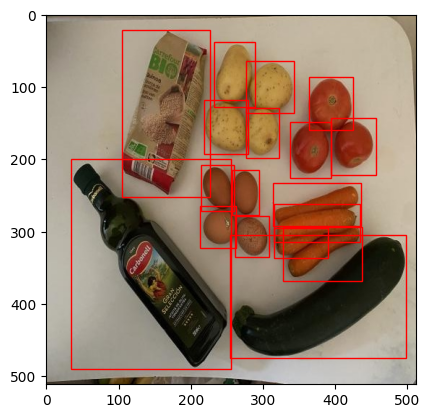

In [70]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image_with_annotations(image_file, annotation_file):
    # Lire l'image
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR en RGB

    # Lire les annotations
    with open(annotation_file, 'r') as file:
        annotations = file.readlines()

    # Afficher l'image
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Dessiner les boîtes englobantes
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        x_center, y_center, width, height = (x_center * image.shape[1], y_center * image.shape[0],
                                             width * image.shape[1], height * image.shape[0])
        rect = patches.Rectangle((x_center - width / 2, y_center - height / 2),
                                 width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Test avec une image et son label
# Assurez-vous que les indices correspondent aux fichiers générés
sample_image_file = os.path.join(rotated_images_directory, "rotated_image_14.jpg")
sample_annotation_file = os.path.join(rotated_annotations_directory, "rotated_annotation_14.txt")

show_image_with_annotations(sample_image_file, sample_annotation_file)


In [36]:
import os
import cv2
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import os
import random
import math

def flip_image(image, flipCode):
    return cv2.flip(image, flipCode)


def flip_annotations(annotations, image_width, image_height, flipCode):
    new_annotations = []
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        if flipCode == 1:  # Flip horizontal
            x_center = 1 - x_center
        elif flipCode == 0:  # Flip vertical
            y_center = 1 - y_center
        elif flipCode == -1:  # Flip both
            x_center = 1 - x_center
            y_center = 1 - y_center
        new_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}\n")
    return new_annotations

def adjust_brightness(image, value):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)


# Fonction pour lire les annotations
def read_annotation(file_path):
    with open(file_path, 'r') as file:
        annotations = file.readlines()
    return annotations


# Fonction pour écrire les nouvelles annotations
def write_annotation(new_file_path, annotations):
    with open(new_file_path, 'w') as file:
        for annotation in annotations:
            file.write(annotation)

def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def adjust_annotations_for_rotation(annotations, image_width, image_height, angle):
    new_annotations = []
    # Convertir l'angle de degrés en radians pour la rotation
    angle_rad = math.radians(angle)

    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())

        # Convertir les coordonnées du centre en pixels
        x_center = x_center * image_width
        y_center = y_center * image_height
        bbox_width = width * image_width
        bbox_height = height * image_height

        # Calculer l'angle de rotation en fonction de l'angle donné
        if angle == 90:
            x_center_new = y_center / image_height
            y_center_new = 1 - (x_center / image_width)
        elif angle == 180:
            x_center_new = 1 - (x_center / image_width)
            y_center_new = 1 - (y_center / image_height)
        elif angle == 270:
            x_center_new = 1 - (y_center / image_height)
            y_center_new = x_center / image_width
        else:
            x_center_new = x_center / image_width
            y_center_new = y_center / image_height

        # Pour une rotation de 90 ou 270 degrés, échangez la largeur et la hauteur de la boîte englobante
        if angle in [90, 270]:
            width_new = bbox_height / image_width
            height_new = bbox_width / image_height
        else:
            width_new = bbox_width / image_width
            height_new = bbox_height / image_height

        # Ajouter la nouvelle annotation à la liste
        new_annotations.append(f"{class_id} {x_center_new} {y_center_new} {width_new} {height_new}\n")

    return new_annotations

# Appliquer une transformation aléatoire à une image
def apply_random_transformation(image, annotations, transformation_type):
    if transformation_type == 'flip':
        flipCode = random.choice([-1, 0, 1])
        transformed_image = flip_image(image, flipCode)
        transformed_annotations = flip_annotations(annotations, image.shape[1], image.shape[0], flipCode)
    elif transformation_type == 'brightness':
        brightness_value = random.randint(-50, 50)
        transformed_image = adjust_brightness(image, brightness_value)
        transformed_annotations = annotations
    elif transformation_type == 'rotate':
        angle = random.choice([0, 90, 180, 270])  # Choix aléatoire d'angle
        transformed_image = rotate_image(image, angle)
        transformed_annotations = adjust_annotations_for_rotation(annotations, image.shape[1], image.shape[0], angle)
    return transformed_image, transformed_annotations

def process_images_annotations(images_directory, annotations_directory, new_images_directory, new_annotations_directory, transformations_dict):
    new_images_count = 0
    files = [f for f in os.listdir(images_directory) if f.endswith(".jpg")]
    random.shuffle(files)  # Shuffle to ensure randomness
    for filename in files:
        file_path = os.path.join(images_directory, filename)
        annotation_path = os.path.join(annotations_directory, filename.replace('.jpg', '.txt'))
        image = cv2.imread(file_path)
        annotations = read_annotation(annotation_path)
        for transformation_type, num_times in transformations_dict.items():
            for _ in range(num_times):
                transformed_image, transformed_annotations = apply_random_transformation(image, annotations, transformation_type)
                new_image_file = os.path.join(new_images_directory, f"{transformation_type}_image_{new_images_count}.jpg")
                new_annotation_file = os.path.join(new_annotations_directory, f"{transformation_type}_annotation_{new_images_count}.txt")
                cv2.imwrite(new_image_file, transformed_image)
                write_annotation(new_annotation_file, transformed_annotations)
                new_images_count += 1

# Paths to the datasets
base_directory = "raw_data/EpicureAi.v4i.yolov8/"
train_images_directory = os.path.join(base_directory, "train/images")
train_annotations_directory = os.path.join(base_directory, "train/labels")
validation_images_directory = os.path.join(base_directory, "valid/images")
validation_annotations_directory = os.path.join(base_directory, "valid/labels")
new_dataset_directory = "raw_data/new_dataset_combined"
new_images_directory = os.path.join(new_dataset_directory, "images")
new_annotations_directory = os.path.join(new_dataset_directory, "labels")
os.makedirs(new_images_directory, exist_ok=True)
os.makedirs(new_annotations_directory, exist_ok=True)

# Calculate the number of transformations
num_train_images = 125  # Update this with the actual number of your training images
num_valid_images = 54   # Update this with the actual number of your validation images
total_images = num_train_images + num_valid_images
num_transformations = 3000  # Total number of transformed images you want
transformations_per_image = num_transformations // total_images

# Define the number of times each transformation should be applied
transformations_dict = {
    'flip': transformations_per_image // 3,
    'brightness': transformations_per_image // 3,
    'rotate': transformations_per_image // 3
}

# Apply transformations on the training dataset
process_images_annotations(train_images_directory, train_annotations_directory, new_images_directory, new_annotations_directory, transformations_dict)

# Adjust the transformations_dict for the validation set if necessary due to rounding
transformations_dict['flip'] += transformations_per_image % 3
process_images_annotations(validation_images_directory, validation_annotations_directory, new_images_directory, new_annotations_directory, transformations_dict)


In [37]:
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Chemins des dossiers mis à jour pour les images et annotations transformées
new_dataset_images_directory = os.path.join(new_dataset_directory, "images")
new_dataset_annotations_directory = os.path.join(new_dataset_directory, "labels")

# Compter les fichiers dans les dossiers
num_images = count_files(new_dataset_images_directory)
num_labels = count_files(new_dataset_annotations_directory)

print("Nombre d'images:", num_images)
print("Nombre de labels:", num_labels)


Nombre d'images: 2464
Nombre de labels: 2464


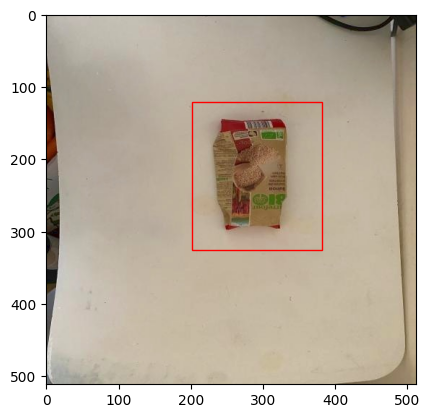

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image_with_annotations(image_file, annotation_file):
    # Vérifier si les fichiers existent
    if not os.path.isfile(image_file) or not os.path.isfile(annotation_file):
        print(f"L'un des fichiers spécifiés n'existe pas: {image_file} ou {annotation_file}")
        return

    # Lire l'image
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR en RGB

    # Lire les annotations
    with open(annotation_file, 'r') as file:
        annotations = [line.strip() for line in file if line.strip()]

    # Afficher l'image et les boîtes englobantes
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        x_center *= image.shape[1]
        y_center *= image.shape[0]
        width *= image.shape[1]
        height *= image.shape[0]
        rect = patches.Rectangle(
            (x_center - width / 2, y_center - height / 2),
            width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

# Utilisation de la fonction avec des chemins de fichiers mis à jour
show_images_directory = os.path.join(new_dataset_directory, "images")
show_annotations_directory = os.path.join(new_dataset_directory, "labels")

sample_image_file = os.path.join(show_images_directory, "brightness_image_1821.jpg")
sample_annotation_file = os.path.join(show_annotations_directory, "brightness_annotation_1821.txt")

show_image_with_annotations(sample_image_file, sample_annotation_file)


In [46]:
!git status


On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Test generate image.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.DS_Store

no changes added to commit (use "git add" and/or "git commit -a")


In [47]:
! git add .


In [48]:
!git commit -m 'new_data augmentation'


[master 5c3c2eb] new_data augmentation
 2 files changed, 529 insertions(+), 95 deletions(-)
 create mode 100644 .DS_Store


In [52]:
!git pull origin master


From github.com:monsieurgoodmood/EpicureAi
 * branch            master     -> FETCH_HEAD
Merge made by the 'ort' strategy.
 .envrc                                        |   2 +
 .gitignore                                    |   1 +
 data/copies_folder/brocolli2_copy_1.png       | Bin 0 -> 90826 bytes
 data/copies_folder/brocolli2_copy_10.png      | Bin 0 -> 90826 bytes
 data/copies_folder/brocolli2_copy_2.png       | Bin 0 -> 90826 bytes
 data/copies_folder/brocolli2_copy_3.png       | Bin 0 -> 90826 bytes
 data/copies_folder/brocolli2_copy_4.png       | Bin 0 -> 90826 bytes
 data/copies_folder/brocolli2_copy_5.png       | Bin 0 -> 90826 bytes
 data/copies_folder/brocolli2_copy_6.png       | Bin 0 -> 90826 bytes
 data/copies_folder/brocolli2_copy_7.png       | Bin 0 -> 90826 bytes
 data/copies_folder/brocolli2_copy_8.png       | Bin 0 -> 90826 bytes
 data/copies_folder/brocolli2_copy_9.png       | Bin 0 -> 90826 bytes
 data/copies_folder/carrot0_copy_1.png         | Bin 0 -> 29979 byt

In [53]:
!git push origin master


Enumerating objects: 14, done.
Counting objects: 100% (14/14), done.
Delta compression using up to 4 threads
Compressing objects: 100% (11/11), done.
Writing objects: 100% (12/12), 900.67 KiB | 5.66 MiB/s, done.
Total 12 (delta 2), reused 1 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), done.
To github.com:monsieurgoodmood/EpicureAi.git
   5cf3844..5eb8f11  master -> master
